# NSGConstantQ Examples

This notebook provides practical examples of use for the NSGConstantQ algorithm. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from essentia import Pool
from essentia import run
import essentia.streaming as es
import essentia.standard as standard

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)
eps = np.finfo(np.float64).eps

## Configuring the algorithm 
In this example the algorithm is configured to analyse a fragment of male singing voice so the analysis frequency range is set accordingly. If the minimum frequency is set to match the freqeuncy of a note (C2 in this case) and the `binsPerOctave` are set to a miltiple of 12, the frequency channels will match an equal tempered scale subdivisions.

`rasterize` controls the interpolation on the frequency channels. If it is set to 'full' frequency channels will have the same lengths. This mode is mandatory in order to broadcast frames in the Streaming mode.  

In order to perform transformations in the constant frequency domain, it is necessary to use both , the forward and backward algorithms. In this case it is essential to configure both algorithms with exactly the same parameters. Thus, probably the eassiest way to do this is with a dictionary like this,

In [14]:
kwargs = {
'inputSize': 4096,
'minFrequency': 65.41,
'maxFrequency': 6000,
'binsPerOctave': 48,
'sampleRate': 44100,
'rasterize': 'full',
'phaseMode': 'global',
'gamma': 0,
'normalize': 'none',
'window': 'hannnsgcq',
}

# Standard mode demostration
Standard mode is very siemple to use. In this example we transform a singing voice utterance into the Gabor domain and compute back its time representation. The main consideration here is to configure the algorithms with the same parameters. It is especially important to set `inputSize` so the inverse algorithm is able to reconstruct the input signal  

In [15]:
x = standard.MonoLoader(filename = '../../audio/vignesh.wav')()[:-1] # Remove the last sample to make the signal even

kwargs['inputSize'] = len(x)

CQStand = standard.NSGConstantQ(**kwargs)

CQIStand = standard.NSGIConstantQ(**kwargs)

NSGConstantQ outputs 3 vectors. The first one is the actual transform and it is a complex time-frequency representation of the input frame. Depending on the `rasterize` parameter it will behave different. If rasterize is set to 'none', each channel will have the minimun length needed give full frequency support to its bandwidth, and it will be returned as a list of lists. 'piecewise' adds a some interpolation so the length of the channels becames a power of 2 in order to perform optimized FFTs. Finally, 'full' rasterization interpolates the channels so they all have the same length and constantq can be returned as a square matrix. I (i.e. a 2D complex numpy matrix). This is the easiest way to manipulate the data. 

DCchannel and NFChannel are only important in order to compute the inverse transform,

In [17]:
constantq, dcchannel, nfchannel = CQStand(x)

y = CQIStand(constantq, dcchannel, nfchannel)

Finally, lets see how our transform looks like,

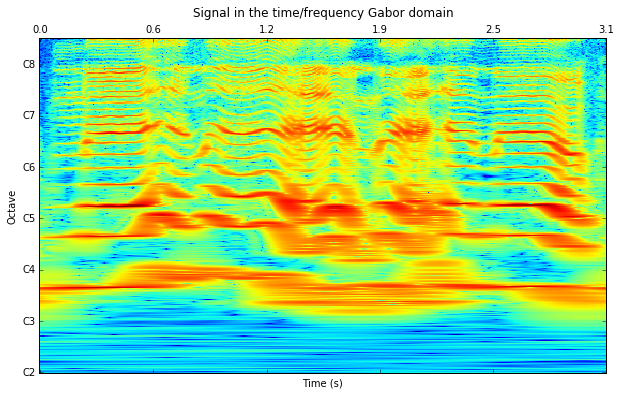

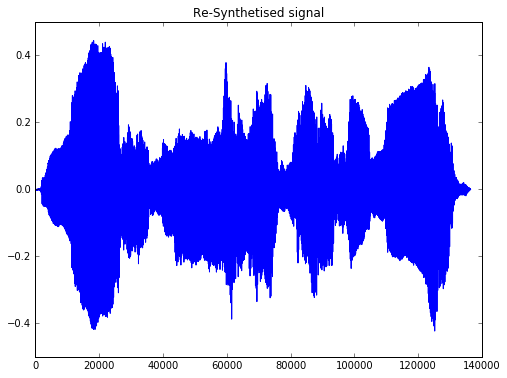

Synthesis SNR: 137.906 dB


In [18]:
# Time labeling
ticksTime = np.linspace(0, len(constantq.T), 6)
secs = np.around(ticksTime * kwargs['inputSize'] /  (kwargs['sampleRate'] * len(constantq.T) ) , decimals=1)

# Octave labeling
ticksFreq = np.arange(0,len(constantq),kwargs['binsPerOctave'])
notes =  ['C%i' %f for f in range(2, len(ticksFreq) +2, 1) ]



plt.matshow(np.log(np.abs(constantq)),origin='lower')
plt.yticks(ticksFreq, notes)
plt.xticks(ticksTime, secs)
plt.ylabel('Octave')
plt.xlabel('Time (s)')
plt.title('Signal in the time/frequency Gabor domain')
plt.show()

plt.plot(y)
plt.title('Re-Synthetised signal')
plt.show()

SNR = np.mean(20*np.log10(np.abs(x[100:-100])/np.abs(x[100:-100]-y[100:-100] + eps) + eps))
print 'Synthesis SNR: %.3f dB' %SNR

Last time this script was executed, the maximun difference between the original and the sinthetized signal was 1.7883e-07. Provided that Essentia analysis is performed using 32-byte floats (eps = 1.192-07), this lets the systhesis error in the range of the numerical error. Thus, it can be considered a theoretically perfect reconstruction. 

# Streaming demostration

Now, lets do the same in Streaming mode. Here we will also perform a frame-wise analysis, suitable for a real time implementation. 
First, lest instantiate the Essentia algorithms needed for the frame-wise analys. We are using CartesianToPolar to save magnitude and phase values as currently it is not possible to save complex arrays in the Essentia Pools.

In [19]:
kwargs['inputSize'] = 4096 

CQAlgo = es.NSGConstantQStreaming(**kwargs)

ICQAlgo = es.NSGIConstantQ(**kwargs)

loader = es.MonoLoader(filename='../../audio/vignesh.wav')

w = es.Windowing(type='triangular',normalized=False, zeroPhase=False)

frameCutter = es.FrameCutter(frameSize=kwargs['inputSize'], hopSize=kwargs['inputSize']/2)

CQc2p = es.CartesianToPolar()
DCc2p = es.CartesianToPolar()
NFc2p = es.CartesianToPolar()

pool = Pool()

Then, lets run the network in order to save the data. The actual transform is sent through the 'constantq' source. It is the only signal needed in order to analyze the signal. However, if the goal is to modify it and go back to the time domain, two extra frequency channels are required, the DC and the Nyquist channels, that contains the information below and above the analysis range. Additionally, a vector called 'framestamps' is returned in order to facilitate the reconstruction of the data. 

- ´constantq´ shape is ( timestamps , number of channels ) 

- ´constantqdc´ shape is ( framestamps , length of th DC channel )

- ´constantqnf´ shape is ( framestamps , length of th Nyquist channel )

- ´framestamps´ shape is ( framestamps )

Framewise vectors are returned once per call. Timewise vectores return more than one token per call and the number depends on the configuration parameters. Using this matrices may be confusing, as the algorithm in which this implementation was inspired was not intended for real time processing. 

In [20]:
# Conecting the algorithms
loader.audio >> frameCutter.signal

frameCutter.frame >> w.frame >> CQAlgo.frame

CQAlgo.constantq >> CQc2p.complex
CQAlgo.constantqdc >> DCc2p.complex
CQAlgo.constantqnf >> NFc2p.complex
CQAlgo.framestamps >> (pool, 'frameStamps')

CQc2p.magnitude >> (pool, 'CQmag')
CQc2p.phase >> (pool, 'CQphas')

DCc2p.magnitude >> (pool, 'DCmag')
DCc2p.phase >> (pool, 'DCphas')

NFc2p.magnitude >> (pool, 'NFmag')
NFc2p.phase >> (pool, 'NFphas')

run(loader)

# Plotting the transform



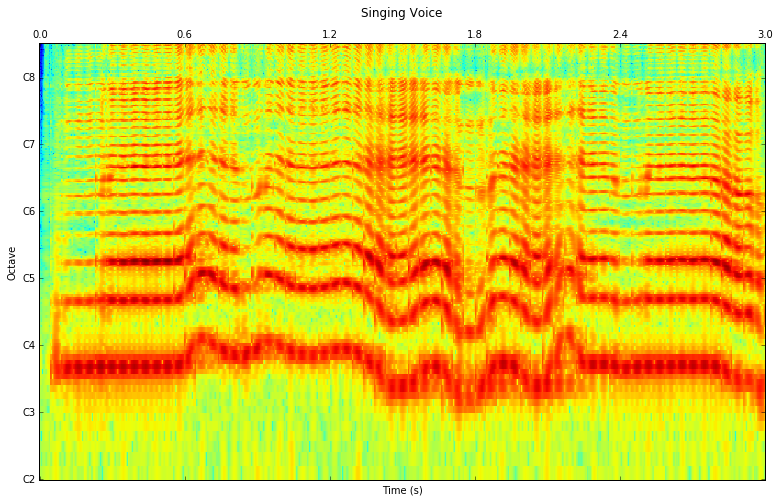

In [21]:
# Time labeling
ticksTime = np.linspace(0, len(pool['CQmag']), 6)
secs = np.around(ticksTime * kwargs['inputSize'] / (2 * kwargs['sampleRate'] * pool['frameStamps'][1] ), decimals=1)

# Octave labeling
ticksFreq = np.arange(0,len(pool['CQmag'].T),kwargs['binsPerOctave'])
notes =  ['C%i' %f for f in range(2, len(ticksFreq) +2, 1) ]


f, ax = plt.subplots(1, figsize = (13,10))
ax.matshow(np.log(pool['CQmag'].T),origin='lower', aspect=2)
plt.yticks(ticksFreq, notes)
plt.xticks(ticksTime, secs)
plt.ylabel('Octave')
plt.xlabel('Time (s)')
plt.title('Singing Voice')
plt.show()

# Reconstruction

This is ugliest cell of this notebook! It shows how to return to the time domain from the data stored in the pool. This is performed using the Standard library again. 

In [22]:
# 1. Remember to synthetize using the same arguments as in the analysis. 
ICQAlgo = standard.NSGIConstantQ(**kwargs)

# 2. Loop to store the frames. DC and Nyquist channels are just tranformed into cartesian coordinates again. 
recFrame = [] 
for i in range(len(pool['DCmag']) -1):
    invDC = standard.PolarToCartesian()(pool['DCmag'][i], pool['DCphas'][i])
    invNF = standard.PolarToCartesian()(pool['NFmag'][i], pool['NFphas'][i])
    
    # 3. CQ frames have to be concatenated. here it is done using the 'frameStamp' vector.  
    invCQ = []
    for j in range(pool['frameStamps'][i], pool['frameStamps'][i+1],1):
        invCQ.append(standard.PolarToCartesian()(pool['CQmag'][j], pool['CQphas'][j]))
    
    # 4. A trick to transpose a list of lists.  
    invCQlist = [list(x) for x in zip(*invCQ)]
    
    # 5. The actual inverse transform. 
    recFrame.append(ICQAlgo(invCQlist, invDC, invNF))


# 6. Overlaped adition of the input. 
frameSize = kwargs['inputSize']
    
y = recFrame[0]

invWindow = standard.Windowing(type='triangular',normalized=False, zeroPhase=False)(standard.essentia.array(np.ones(frameSize)))


for i in range(1,len(recFrame)):
    y = np.hstack([y,np.zeros(frameSize/2)])
    y[-frameSize:] = y[-frameSize:] + recFrame[i] 
    
y = y[frameSize/2:]

Finaly, we can compare the original and the synthetised signals and compute the SNR of the algorithm 

SNR: 141.321 dB


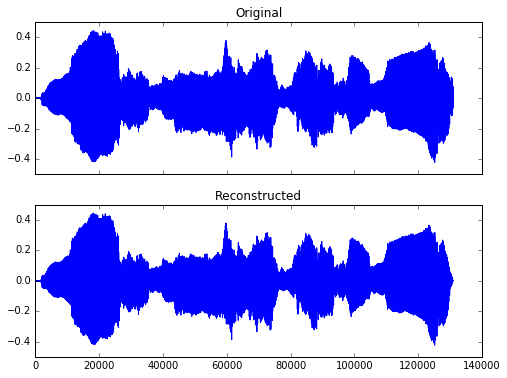

In [23]:
x = standard.MonoLoader(filename = '../../audio/vignesh.wav')()
xtest = x[:len(y)]

SNR = np.mean(20*np.log10(np.abs(xtest)/np.abs(xtest-y + eps) + eps))
print 'SNR: %.3f dB' %SNR

_, ax = plt.subplots(2, sharex=True)
ax[0].plot(xtest)
ax[0].set_title('Original')
ax[1].plot(y)
ax[1].set_title('Reconstructed')
plt.show()